In [11]:
import pickle
from scipy.sparse import csr_matrix
from clustering import visualize_silhouette_clusters, compare_true_labels
import numpy as np
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
from soyclustering import SphericalKMeans, visualize_pairwise_distance
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups


raw_posts = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

with open('data/reviews/minsupp_0.35/itemset_features.pkl', 'rb') as f:
    itemset_features = pickle.load(f)
    
with open('data/reviews_labels.pkl', 'rb') as f:
    true_labels = pickle.load(f)
    
print("num of groundtruth labels:", len(np.unique(true_labels)))

num of groundtruth labels: 5


In [14]:
# adjust number of clusters
my_num_clusters = 5

# convert itemset_features to a sparse matrix that SphericalKMeans will accept
itemset_matrix = csr_matrix(itemset_features.astype(int))
density = itemset_matrix.getnnz() / np.prod(itemset_matrix.shape)
print("density of matrix:", density)

spherical_kmeans = SphericalKMeans(
        n_clusters=my_num_clusters,
        max_iter=100,
        verbose=1,
        init='similar_cut',
        #sparsity='minimum_df',
        minimum_df_factor=0.05
    )

sphkmeans_cluster_labels = spherical_kmeans.fit_predict(itemset_matrix)
print('finished spherical clustering')

compare_true_labels(true_labels, sphkmeans_cluster_labels, itemset_features)

density of matrix: 0.4448798732624206
initialization_time=0.001506 sec, sparsity=0.495
n_iter=1, changed=2116, inertia=690.340, iter_time=0.029 sec, sparsity=0.557
n_iter=2, changed=25, inertia=545.487, iter_time=0.026 sec, sparsity=0.562
n_iter=3, changed=3, inertia=545.507, iter_time=0.028 sec, sparsity=0.562
n_iter=4, changed=0, inertia=545.514, iter_time=0.029 sec, sparsity=0.562
Early converged.
finished spherical clustering
Adjusted Rand Index: -0.031196362771680038
Normalized Mutual Information: 0.1121328388262496
Homogeneity: 0.13242064609882254
Completeness: 0.09723563194078215
V-Measure: 0.11213283882624958
Silhouette Score: 0.18988099764188363


In [10]:
# KModes clustering

km = KModes(n_clusters=my_num_clusters, init='Huang', n_init=5, verbose=1, n_jobs=-1)
kmodes_cluster_labels = km.fit_predict(itemset_features)

compare_true_labels(true_labels, kmodes_cluster_labels, itemset_features)


Best run was number 5
Adjusted Rand Index: 0.3006148319725748
Normalized Mutual Information: 0.5131135940041882
Homogeneity: 0.7215558457814666
Completeness: 0.39810846309852066
V-Measure: 0.5131135940041882
Silhouette Score: 0.43409483644314256


In [9]:
# Agglomerative clustering

distances = cosine_distances(itemset_features)

agglo_clustering = AgglomerativeClustering(n_clusters=my_num_clusters, metric="precomputed", linkage="average")
agglo_labels = agglo_clustering.fit_predict(distances)

compare_true_labels(true_labels, agglo_labels, itemset_features)



Adjusted Rand Index: -0.02301348456262223
Normalized Mutual Information: 0.024647592997428695
Homogeneity: 0.01469889953736338
Completeness: 0.07626879495575457
V-Measure: 0.024647592997428695
Silhouette Score: 0.2337872559622674


In [ ]:
## RANDOM VISUALIZATION STUFF BELOW

For n_clusters = 5 The average silhouette_score is : 0.04823742611217405


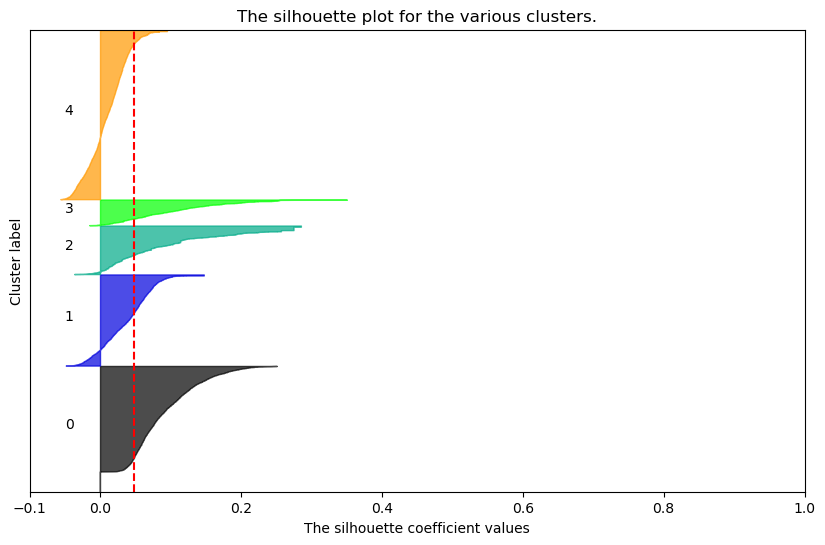

In [4]:
## Silhouette plot to visualize how good clusters are: if they are good, should see more on the right side
## Good average silhouette score apparently should be >0.5?

# Subsample before trying to do silhouette visualization, IF dataset is too big
subsample = False
if subsample:
    subsample_size = 10000  # Adjust as needed

    # Generate random indices for subsampling
    random_indices = np.random.choice(len(itemset_features), subsample_size, replace=False)

    subsample_itemset_features = itemset_features[random_indices]
    subsample_sphkmeans_cluster_labels = sphkmeans_cluster_labels[random_indices]
    visualize_silhouette_clusters(subsample_sphkmeans_cluster_labels, subsample_itemset_features, metric='cosine')
else:
    visualize_silhouette_clusters(sphkmeans_cluster_labels, itemset_features, metric='cosine')

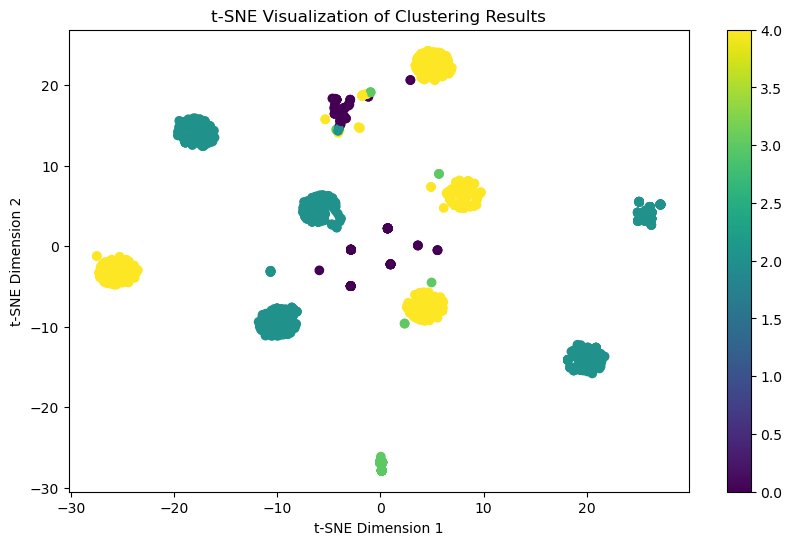

In [16]:
## using t-sne (alternative to pca) to visualize

# Calculate cosine distances between binary vectors
cosine_distances_matrix = cosine_distances(itemset_features)

# Create a t-SNE instance with cosine distance
tsne = TSNE(n_components=2, metric="precomputed", perplexity=30, learning_rate=200, init="random")

# Fit t-SNE to the cosine distance matrix
tsne_results = tsne.fit_transform(cosine_distances_matrix)

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))


plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=sphkmeans_cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Clustering Results')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


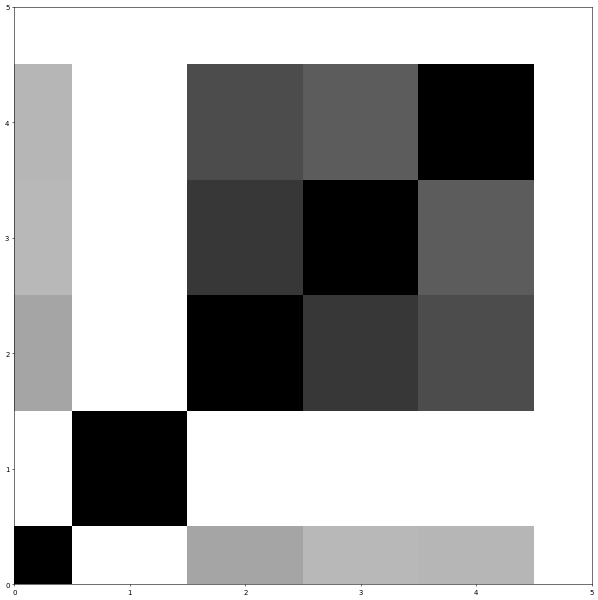

In [17]:
# function included with the sphericalkmeans library to evaluate the distance between the clusters
# dark means closer, light means further away - think ideally should have more light squares?

sphkmeans_centers = spherical_kmeans.cluster_centers_

fig = visualize_pairwise_distance(centers=sphkmeans_centers,
                                  labels=sphkmeans_cluster_labels, 
                                  max_dist=1, 
                                  sort=False)

In [ ]:
# extra

#agglomerative clustering

# from sklearn.metrics.pairwise import cosine_similarity
# Compute the cosine similarity matrix
# similarity = cosine_similarity(itemset_features)
# print(similarity.__sizeof__()/1024)
